<h1 align=center><font size = 8>Battle of the Neighborhoods</font></h1>

<h2><font size = 3>Overview</font></h2>

In this project, we will examine the data regarding venues that serve plant-based or vegetarian/vegan diets in Metro Manila, Philippines.

<h2><font size = 3>Methodology</font></h2>

I will make use of Foursquare data to determine how many venues are returned from queries on plant diet, vegetarian, vegan, or salad keywords for each city in Metro Manila. With this data, I will seek to:<br>
1. determine the city in Metro Manila, Philippines that has the most number of venues that serve these foods,
2. find out the barangay that would be an attractive spot to setup a new venue

Also, using data from the 2015 Family Income and Expenditure Survey of the Philippine Statistics Authority, I will segment the Metro Manila consumer market and see which segment can be targeted for plant-based or vegetarian/vegan diets. The dataset has been modified to only include data from Metro Manila (Region VIII - National Capital Region).

<h2><font size = 3>Rationale</font></h2>

This study can be used by consumers to know which city has the most vegetarian/vegan venues. For the entrepreneurs and business owners, this study could help point out opportunity areas to develop the market for vegetarian/vegan diets.

<h2><font size = 3>Output</font></h2>

1. Choropleth map of Manila showing population density
2. Foursquare data on nearby vegetarian/vegan venues in Manila
3. Choropleth map of Manila with markers for vegetarian/vegan venues
4. Market segmentation using k-means


<h2><font size = 3>Introduction</font></h2>

More and more studies, articles, and documentaries have come out on the benefits of plant-based diets. A few of these articles/studies are as follows:

> "Plant-based diets can help reduce your risk of heart disease, but they're not all created equal.", (January 2018), https://www.health.harvard.edu/staying-healthy/the-right-plant-based-diet-for-you

> "Eat more plants and less meat to live longer and improve heart health, study suggests", (August 2019), https://edition.cnn.com/2019/08/09/health/plant-based-diet-heart-disease-study/index.html

> "Research Confirms a Plant-Based Diet Can Help You Live Longer", (December 2018), https://nutritionstudies.org/research-confirms-a-plant-based-diet-can-help-you-live-longer/

> "Plant-Based Diets, The Power of a Plant-Based Diet for Good Health", https://www.pcrm.org/good-nutrition/plant-based-diets

> "A healthy lifestyle", http://www.euro.who.int/en/health-topics/disease-prevention/nutrition/a-healthy-lifestyle

> "AMA Passes Resolution: Hospitals Should Provide Plant-Based Meals and Remove Cancer-Causing Processed Meats", (June 2017) https://www.pcrm.org/news/news-releases/ama-passes-resolution-hospitals-should-provide-plant-based-meals-and-remove

> "The 33 Best Vegan Documentaries (Ultimate List)", (November 2019), https://nutriciously.com/best-vegan-documentaries/


<br>
I am by no means an expert on nutrition and I am not trying to convince anyone. I also would not want to debate on the merits or demerits of these studies, articles, or documentaries. However, for those who are looking for a plan-based, vegetarian, vegan diet for one reason or another, let us explore the areas where you can get your plant food fix. While Filipino food includes vegetables, several of them still have meat in the dish, though there are also several Filipino dishes that are only made from vegetables.

First let us install and/or import any library or package that we need.

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# !conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium
from folium.features import DivIcon

!pip install xlrd # needed for read_excel

# !conda install -c conda-forge geopy --yes 
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!pip install geopandas
import geopandas as gpd

import requests # library to handle requests

print('Libraries imported!')

     |████████████████████████████████| 92kB 12.9MB/s eta 0:00:01
     |████████████████████████████████| 921kB 14.4MB/s eta 0:00:01
     |████████████████████████████████| 11.8MB 41.2MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 41.4MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 45.2MB/s eta 0:00:01
Libraries imported!


Let us then explore the geography of Manila and see the population density.

Let's get the 2015 population file from the Philippine Statistics Authority website.

In [2]:
population_file = 'https://psa.gov.ph/sites/default/files/attachments/hsd/specialrelease/2015%20Urban%20Rural%20Press%20Release_Statistical%20Tables_0.xlsx'

# reads the excel file under sheet "T1", skips the first 7 rows and does not assign any header
# we will assign the column names later ourselves
population = pd.read_excel(population_file,sheet_name='T1', skiprows=7, header=None)
population.head()

0           1           2           3           4  \
0  NATIONAL CAPITAL REGION  12877253.0  11855975.0  12877253.0  11855975.0   
1           CITY OF MANILA   1780148.0   1652171.0   1780148.0   1652171.0   
2      CITY OF MANDALUYONG    386276.0    328699.0    386276.0    328699.0   
3         CITY OF MARIKINA    450741.0    424150.0    450741.0    424150.0   
4            CITY OF PASIG    755300.0    669773.0    755300.0    669773.0   

       5      6  
0  100.0  100.0  
1  100.0  100.0  
2  100.0  100.0  
3  100.0  100.0  
4  100.0  100.0

Let's assign the column names and add a new column with the city names that corresponds to the list from the geojson file that we will be using later on.

In [3]:
# adds the names of the columns
population.rename(columns={0:'City',1:'Total-2015',2:'Total-2010',3:'Urban-2015',4:'Urban-2010',5:'%-2015',6:'%-2010'},inplace=True)

# takes only the first 17 rows for the Metro Manila data
population=population.loc[0:17,:]

# inserts a new column with the city names corresponding to the geojson file that we will use later on
cities=['Metro Manila','Manila','Mandaluyong','Marikina','Pasig City','Quezon City','San Juan','Kalookan City',
        'Malabon','Navotas','Valenzuela','Las Piñas','Makati City','Muntinlupa','Parañaque','Pasay City','Pateros','Taguig']
population.insert(loc=1,column='City2',value=cities,allow_duplicates=False)

#excludes the first row which corresponds to the total for the whole Metro Manila area
population=population.iloc[1:,:].reset_index()
population=population.iloc[:,1:]
population

City          City2  Total-2015  Total-2010  Urban-2015  \
0        CITY OF MANILA         Manila   1780148.0   1652171.0   1780148.0   
1   CITY OF MANDALUYONG    Mandaluyong    386276.0    328699.0    386276.0   
2      CITY OF MARIKINA       Marikina    450741.0    424150.0    450741.0   
3         CITY OF PASIG     Pasig City    755300.0    669773.0    755300.0   
4           QUEZON CITY    Quezon City   2936116.0   2761720.0   2936116.0   
5      CITY OF SAN JUAN       San Juan    122180.0    121430.0    122180.0   
6         CALOOCAN CITY  Kalookan City   1583978.0   1489040.0   1583978.0   
7       CITY OF MALABON        Malabon    365525.0    353337.0    365525.0   
8       CITY OF NAVOTAS        Navotas    249463.0    249131.0    249463.0   
9    CITY OF VALENZUELA     Valenzuela    620422.0    575356.0    620422.0   
10    CITY OF LAS PIÑAS      Las Piñas    588894.0    552573.0    588894.0   
11       CITY OF MAKATI    Makati City    582602.0    529039.0    582602.0   
12   CITY OF MUNTINLUPA     Muntinlupa    504509.0    459941.0    504509.0   
13    CITY OF PARAÑAQUE      Parañaque    665822.0    588126.0    665822.0   
14           PASAY CITY     Pasay City    416522.0    392869.0    416522.0   
15              PATEROS        Pateros     63840.0     64147.0     63840.0   
16          TAGUIG CITY         Taguig    804915.0    644473.0    804915.0   

    Urban-2010  %-2015  %-2010  
0    1652171.0   100.0   100.0  
1     328699.0   100.0   100.0  
2     424150.0   100.0   100.0  
3     669773.0   100.0   100.0  
4    2761720.0   100.0   100.0  
5     121430.0   100.0   100.0  
6    1489040.0   100.0   100.0  
7     353337.0   100.0   100.0  
8     249131.0   100.0   100.0  
9     575356.0   100.0   100.0  
10    552573.0   100.0   100.0  
11    529039.0   100.0   100.0  
12    459941.0   100.0   100.0  
13    588126.0   100.0   100.0  
14    392869.0   100.0   100.0  
15     64147.0   100.0   100.0  
16    644473.0   100.0   100.0

Let's get the latitude and longitude of each city.

In [4]:
# adds 2 new columns for latitude and longitude
population = population.reindex(population.columns.tolist() + ['Latitude','Longitude'], axis=1)

# gets the latitude and longitude using the geocode function and adds the data to the dataframe
for index in population['City2'].index:
    address =  population.loc[index, 'City2'] + ', Philippines'
    geolocator = Nominatim(user_agent="mm_agent")
    location = geolocator.geocode(address)
    population.loc[index,'Latitude'] = location.latitude
    population.loc[index,'Longitude'] = location.longitude

# removes the unused columns from the population file
population.drop(['Total-2010','Urban-2015','Urban-2010','%-2015','%-2010'],axis=1,inplace=True)
population

City          City2  Total-2015   Latitude   Longitude
0        CITY OF MANILA         Manila   1780148.0  14.590622  120.979970
1   CITY OF MANDALUYONG    Mandaluyong    386276.0  14.577781  121.033230
2      CITY OF MARIKINA       Marikina    450741.0  14.633108  121.099354
3         CITY OF PASIG     Pasig City    755300.0  14.578411  121.081915
4           QUEZON CITY    Quezon City   2936116.0  14.650991  121.048615
5      CITY OF SAN JUAN       San Juan    122180.0  14.602301  121.039287
6         CALOOCAN CITY  Kalookan City   1583978.0  14.657129  120.984107
7       CITY OF MALABON        Malabon    365525.0  14.675233  120.957354
8       CITY OF NAVOTAS        Navotas    249463.0  14.656982  120.947804
9    CITY OF VALENZUELA     Valenzuela    620422.0  14.707735  120.946172
10    CITY OF LAS PIÑAS      Las Piñas    588894.0  14.480609  120.981910
11       CITY OF MAKATI    Makati City    582602.0  14.556885  121.023532
12   CITY OF MUNTINLUPA     Muntinlupa    504509.0  14.394061  121.041044
13    CITY OF PARAÑAQUE      Parañaque    665822.0  14.500702  120.991549
14           PASAY CITY     Pasay City    416522.0  14.543700  120.994650
15              PATEROS        Pateros     63840.0  14.544491  121.066186
16          TAGUIG CITY         Taguig    804915.0  14.526625  121.074403

Let us confirm the row counts for all the columns.

In [5]:
population.describe(include='all')

City      City2    Total-2015   Latitude   Longitude
count            17         17  1.700000e+01  17.000000   17.000000
unique           17         17           NaN        NaN         NaN
top     TAGUIG CITY  Las Piñas           NaN        NaN         NaN
freq              1          1           NaN        NaN         NaN
mean            NaN        NaN  7.574855e+05  14.581021  121.017122
std             NaN        NaN  7.190457e+05   0.080009    0.048273
min             NaN        NaN  6.384000e+04  14.394061  120.946172
25%             NaN        NaN  3.862760e+05  14.543700  120.981910
50%             NaN        NaN  5.826020e+05  14.578411  121.023532
75%             NaN        NaN  7.553000e+05  14.650991  121.048615
max             NaN        NaN  2.936116e+06  14.707735  121.099354

Let's get the latitude and longitude for Metro Manila itself and create a generic map of the area.

In [6]:
# gets the latitude and longitude of Metro Manila
address = 'Metro Manila, Philippines'

geolocator = Nominatim(user_agent="mm_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

# create a plain Metro Manila map
mm_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# display world map
mm_map

14.5736108 121.0329706


Let's assign the geojson file to a variable and using this geojson file and the latitude and longitude data on the dataframe, create the choropleth map of Metro Manila showing the population density as of 2015.

In [7]:
# assign the Metro Manila geojson file to a variable
mm_geo = r'https://raw.githubusercontent.com/macoymejia/geojsonph/master/Philippines/Luzon/Metropolitant%20Manila/MetropolitantManila.json' # geojson file

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
mm_map.choropleth(
    geo_data=mm_geo,
    data=population,
    columns=['City2', 'Total-2015'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Metro Manila Population'
)

# displays the text on top of the choropleth map
for lat1, lon1, text1 in zip(population['Latitude'], population['Longitude'], population['City2']):
    folium.Marker([lat1,lon1], icon=DivIcon(
        icon_size=(2,1),
        icon_anchor=(0,0),
        html='<div style="font-size: 10pt; color : black">'+text1+'</div>',
        )).add_to(mm_map)

# adds circle markers based on the latitude and longitude of the cities
for lat, lng, label in zip(population['Latitude'], population['Longitude'], population['City2']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mm_map)
    
# display map
mm_map


/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


As you can see from the map, Quezon City is the most populous city followed by Manila and Kalookan.

For some of the cities, the latitude and longitude that we obtained are not the center of the city. Let's get the centroids of the cities from the geojson file.

In [8]:
mm_geo = r'https://raw.githubusercontent.com/macoymejia/geojsonph/master/Philippines/Luzon/Metropolitant%20Manila/MetropolitantManila.json' # geojson file

gpdjson = gpd.read_file(mm_geo)

print(type(gpdjson))

gpdjson

<class 'geopandas.geodataframe.GeoDataFrame'>


ID_0  ISO       NAME_0  ID_1               NAME_1  ID_2         NAME_2  \
0    177  PHL  Philippines    47  Metropolitan Manila   950  Kalookan City   
1    177  PHL  Philippines    47  Metropolitan Manila   951      Las Piñas   
2    177  PHL  Philippines    47  Metropolitan Manila   952    Makati City   
3    177  PHL  Philippines    47  Metropolitan Manila   953        Malabon   
4    177  PHL  Philippines    47  Metropolitan Manila   954    Mandaluyong   
5    177  PHL  Philippines    47  Metropolitan Manila   955         Manila   
6    177  PHL  Philippines    47  Metropolitan Manila   956       Marikina   
7    177  PHL  Philippines    47  Metropolitan Manila   957     Muntinlupa   
8    177  PHL  Philippines    47  Metropolitan Manila   958        Navotas   
9    177  PHL  Philippines    47  Metropolitan Manila   959      Parañaque   
10   177  PHL  Philippines    47  Metropolitan Manila   960     Pasay City   
11   177  PHL  Philippines    47  Metropolitan Manila   961     Pasig City   
12   177  PHL  Philippines    47  Metropolitan Manila   962        Pateros   
13   177  PHL  Philippines    47  Metropolitan Manila   963    Quezon City   
14   177  PHL  Philippines    47  Metropolitan Manila   964       San Juan   
15   177  PHL  Philippines    47  Metropolitan Manila   965         Taguig   
16   177  PHL  Philippines    47  Metropolitan Manila   966     Valenzuela   

   NL_NAME_2                       VARNAME_2           TYPE_2 ENGTYPE_2  \
0       None                            None  Lungsod|Siyudad      City   
1       None              Las Piñas, City of  Lungsod|Siyudad      City   
2       None                 Makati, City of  Lungsod|Siyudad      City   
3       None                            None  Lungsod|Siyudad      City   
4       None            Mandaluyong, City of  Lungsod|Siyudad      City   
5       None  City of Manila|Manila, City of  Lungsod|Siyudad      City   
6       None               Marikina, City of  Lungsod|Siyudad      City   
7       None             Muntinlupa, City of  Lungsod|Siyudad      City   
8       None                            None  Lungsod|Siyudad      City   
9       None              Parañaque, City of  Lungsod|Siyudad      City   
10      None                            None  Lungsod|Siyudad      City   
11      None                  Pasig, City of  Lungsod|Siyudad      City   
12      None                            None  Lungsod|Siyudad      City   
13      None                            None  Lungsod|Siyudad      City   
14      None                            None  Lungsod|Siyudad      City   
15      None                            None  Lungsod|Siyudad      City   
16      None             Valenzuela, City of  Lungsod|Siyudad      City   

               PROVINCE               REGION  \
0   Metropolitan Manila  Metropolitan Manila   
1   Metropolitan Manila  Metropolitan Manila   
2   Metropolitan Manila  Metropolitan Manila   
3   Metropolitan Manila  Metropolitan Manila   
4   Metropolitan Manila  Metropolitan Manila   
5   Metropolitan Manila  Metropolitan Manila   
6   Metropolitan Manila  Metropolitan Manila   
7   Metropolitan Manila  Metropolitan Manila   
8   Metropolitan Manila  Metropolitan Manila   
9   Metropolitan Manila  Metropolitan Manila   
10  Metropolitan Manila  Metropolitan Manila   
11  Metropolitan Manila  Metropolitan Manila   
12  Metropolitan Manila  Metropolitan Manila   
13  Metropolitan Manila  Metropolitan Manila   
14  Metropolitan Manila  Metropolitan Manila   
15  Metropolitan Manila  Metropolitan Manila   
16  Metropolitan Manila  Metropolitan Manila   

                                             geometry  
0   MULTIPOLYGON (((121.01953 14.68939, 121.01971 ...  
1   MULTIPOLYGON (((120.98571 14.48585, 120.98588 ...  
2   POLYGON ((121.02175 14.57696, 121.02316 14.576...  
3   POLYGON ((120.93583 14.69478, 120.93593 14.694...  
4   POLYGON ((121.05737 14.60128, 121.05743 14.601...  
5   POLYGON ((120.97886 14.63668, 120.97897 14.

In [9]:
# gets the latitude and longitude of the centroids from the geojson file and adds to the population dataframe
gpdjson['Center Lat']=1/1
gpdjson['Center Long']=1/1
population['Center Lat']=1/1
population['Center Long']=1/1
for ind in gpdjson.index:
    gpdjson.loc[ind,'Center Lat']=list(gpdjson['geometry'][ind].centroid.coords)[0][1]
    gpdjson.loc[ind,'Center Long']=list(gpdjson['geometry'][ind].centroid.coords)[0][0]
    population.loc[population['City2']==gpdjson.loc[ind,'NAME_2'],'Center Lat']=list(gpdjson['geometry'][ind].centroid.coords)[0][1]
    population.loc[population['City2']==gpdjson.loc[ind,'NAME_2'],'Center Long']=list(gpdjson['geometry'][ind].centroid.coords)[0][0]
    print(ind, gpdjson.loc[ind,'NAME_2'], gpdjson.loc[ind,'Center Lat'], gpdjson.loc[ind,'Center Long'])

# gpdjson
population

0 Kalookan City 14.724493457370523 121.03331225019011
1 Las Piñas 14.442908840649698 120.99387121297853
2 Makati City 14.549431266951789 121.03359062087557
3 Malabon 14.672041911067014 120.95772329343328
4 Mandaluyong 14.584232358124824 121.03904141527106
5 Manila 14.599744015701697 120.98468682963933
6 Marikina 14.647183622042915 121.10301308402966
7 Muntinlupa 14.401976359471771 121.03278467151291
8 Navotas 14.663472662552186 120.94397357196081
9 Parañaque 14.483853801272074 121.01450368551413
10 Pasay City 14.531090435226252 121.00413647661057
11 Pasig City 14.582509717833537 121.08423826489971
12 Pateros 14.547189122546769 121.06941431372131
13 Quezon City 14.674280467837972 121.05749860208041
14 San Juan 14.602955279873703 121.03381721411573
15 Taguig 14.514696945710922 121.0660524030914
16 Valenzuela 14.704170851722742 120.98238028141049


City          City2  Total-2015   Latitude   Longitude  \
0        CITY OF MANILA         Manila   1780148.0  14.590622  120.979970   
1   CITY OF MANDALUYONG    Mandaluyong    386276.0  14.577781  121.033230   
2      CITY OF MARIKINA       Marikina    450741.0  14.633108  121.099354   
3         CITY OF PASIG     Pasig City    755300.0  14.578411  121.081915   
4           QUEZON CITY    Quezon City   2936116.0  14.650991  121.048615   
5      CITY OF SAN JUAN       San Juan    122180.0  14.602301  121.039287   
6         CALOOCAN CITY  Kalookan City   1583978.0  14.657129  120.984107   
7       CITY OF MALABON        Malabon    365525.0  14.675233  120.957354   
8       CITY OF NAVOTAS        Navotas    249463.0  14.656982  120.947804   
9    CITY OF VALENZUELA     Valenzuela    620422.0  14.707735  120.946172   
10    CITY OF LAS PIÑAS      Las Piñas    588894.0  14.480609  120.981910   
11       CITY OF MAKATI    Makati City    582602.0  14.556885  121.023532   
12   CITY OF MUNTINLUPA     Muntinlupa    504509.0  14.394061  121.041044   
13    CITY OF PARAÑAQUE      Parañaque    665822.0  14.500702  120.991549   
14           PASAY CITY     Pasay City    416522.0  14.543700  120.994650   
15              PATEROS        Pateros     63840.0  14.544491  121.066186   
16          TAGUIG CITY         Taguig    804915.0  14.526625  121.074403   

    Center Lat  Center Long  
0    14.599744   120.984687  
1    14.584232   121.039041  
2    14.647184   121.103013  
3    14.582510   121.084238  
4    14.674280   121.057499  
5    14.602955   121.033817  
6    14.724493   121.033312  
7    14.672042   120.957723  
8    14.663473   120.943974  
9    14.704171   120.982380  
10   14.442909   120.993871  
11   14.549431   121.033591  
12   14.401976   121.032785  
13   14.483854   121.014504  
14   14.531090   121.004136  
15   14.547189   121.069414  
16   14.514697   121.066052

In [10]:
# assign the Metro Manila geojson file to a variable
mm_geo = r'https://raw.githubusercontent.com/macoymejia/geojsonph/master/Philippines/Luzon/Metropolitant%20Manila/MetropolitantManila.json' # geojson file

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
mm_map.choropleth(
    geo_data=mm_geo,
    data=population,
    columns=['City2', 'Total-2015'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Metro Manila Population'
)

# displays the text on top of the choropleth map
for lat1, lon1, text1 in zip(population['Latitude'], population['Longitude'], population['City2']):
    folium.Marker([lat1,lon1], icon=DivIcon(
        icon_size=(2,1),
        icon_anchor=(0,0),
        html='<div style="font-size: 10pt; color : black">'+text1+'</div>',
        )).add_to(mm_map)

# adds circle markers based on the latitude and longitude of the cities
for lat, lng, label in zip(population['Center Lat'], population['Center Long'], population['City2']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mm_map)
    
# display map
mm_map

While still not perfect, the latitude and longitudes are now closer to the center of the cities.

Now let's start checking venues using the Foursquare API.

In [11]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: CLIENT_ID
CLIENT_SECRET:CLIENT_SECRET


As a first example, let's get the latitude and longitude of Quezon City.

Next, let's define the parameters for the Foursquare API to search for vegan places that are within a radius of 10km from the Quezon City latitude and longitude.

In [12]:
# type your answer here
latitude = population.loc[population['City2']=='Quezon City','Center Lat'].values[0]
longitude = population.loc[population['City2']=='Quezon City','Center Long'].values[0]
search_query = 'vegan'
radius = 10000
LIMIT = 100
print(latitude)
print(longitude)
print(search_query + ' .... OK!')

# Search
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

# Search without radius
# url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, LIMIT)
# url

# Explore
# url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
# url


14.674280467837972
121.05749860208041
vegan .... OK!


'https://api.foursquare.com/v2/venues/search?client_id=BHHXK3RAJXKFFISQWLOOSP3QEVYBTAHJWSS2VIGPAXQNLRKV&client_secret=DHUCKPZT2VHBHEIFEEDXO4DD5QHZAKJDQ4JGEGG2GN3GV4T3&ll=14.674280467837972,121.05749860208041&v=20180605&query=vegan&radius=10000&limit=100'

Let's send the request to the Foursquare API.

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5df1cc43b1cac0001bcd3512'},
 'response': {'venues': [{'id': '59be72b9112c6c507026bf9f',
    'name': 'The Vegan Grocer Ph',
    'location': {'address': '201 Recto',
     'lat': 14.595767,
     'lng': 121.039996,
     'labeledLatLngs': [{'label': 'display',
       'lat': 14.595767,
       'lng': 121.039996}],
     'distance': 8941,
     'postalCode': '1500',
     'cc': 'PH',
     'city': 'San Juan',
     'state': 'San Juan',
     'country': 'Pilipinas',
     'formattedAddress': ['201 Recto',
      '1500 San Juan City',
      'San Juan',
      'Pilipinas']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b45',
      'name': 'Organic Grocery',
      'pluralName': 'Organic Groceries',
      'shortName': 'Organic Grocery',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1576127572',
    'hasPerk': False},
   {'id': '4f9b60ffe4b0ec21f4a3356d',
  

Let us get just the relevant venues data into a dataframe.

In [14]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe

categories  hasPerk  \
0  [{'id': '52f2ab2ebcbc57f1066b8b45', 'name': 'O...    False   
1  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
2  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
3  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
4  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
5  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
6  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
7  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   
8  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...    False   

                         id                               location.address  \
0  59be72b9112c6c507026bf9f                                      201 Recto   
1  4f9b60ffe4b0ec21f4a3356d                                            NaN   
2  4f49cbf9e4b0922ac6a27349                                    Tiendesitas   
3  5953a56c95a72241ed720c50                                            NaN   
4  50ab0fc2e4b09bb9200e768b                                    Earnshaw St   
5  5d207be44dcbca002fcf9b95                                            NaN   
6  4ec894f6cc21b428e469b19e                                            NaN   
7  527bc0ae11d24c70578ab5c6  Annville Subdivision, Maysan, Valenzuela City   
8  5ca059ca67a9fe002ce69227                      Food Village, Tiendesitas   

  location.cc     location.city location.country  \
0          PH          San Juan        Pilipinas   
1          PH               NaN        Pilipinas   
2          PH               NaN        Pilipinas   
3          PH     Marikina City        Pilipinas   
4          PH               NaN        Pilipinas   
5          PH  Mandaluyong City        Pilipinas   
6          PH               NaN        Pilipinas   
7          PH        Valenzuela        Pilipinas   
8          PH             Pasig        Pilipinas   

                     location.crossStreet  location.distance  \
0                                     NaN               8941   
1                                     NaN               3210   
2                                     NaN              10046   
3                                     NaN               7653   
4                                     NaN              10412   
5                                     NaN              10314   
6                                     NaN              11731   
7                      along Annville St.               9903   
8  Ortigas Avenue cor E. Rodriguez Avenue              10078   

                           location.formattedAddress  \
0  [201 Recto, 1500 San Juan City, San Juan, Pili...   
1                                        [Pilipinas]   
2                           [Tiendesitas, Pilipinas]   
3               [1809 Marikina, Marikina, Pilipinas]   
4                           [Earnshaw St, Pilipinas]   
5   [Mandaluyong, Lungsod ng Mandaluyong, Pilipinas]   
6                                        [Pilipinas]   
7  [Annville Subdivision, Maysan, Valenzuela City...   
8  [Food Village, Tiendesitas (Ortigas Avenue cor...   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 14.595767, 'lng':...     14.595767   
1  [{'label': 'display', 'lat': 14.645441, 'lng':...     14.645441   
2  [{'label': 'display', 'lat': 14.58613716840479...     14.586137   
3  [{'label': 'display', 'lat': 14.661597, 'lng':...     14.661597   
4  [{'label': 'display', 'lat': 14.60450839996337...     14.604508   
5  [{'label': 'display', 'lat': 14.581655, 'lng':...     14.581655   
6  [{'label': 'display', 'lat': 14.57526355152843...     14.575264   
7  [{'label': 'display', 'lat': 14.70189891968088...     14.701899   
8  [{'label': 'display', 'lat': 14.585968, 'lng':...     14.585968   

   location.lng location.postalCode          location.state  \
0    121.039996                1500                San Juan   
1    121.056948                 NaN                     NaN 

Let's further remove columns that we don't need and then extract the category of the venue.

In [15]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name                     categories  \
0   The Vegan Grocer Ph                Organic Grocery   
1                 Vegan  Vegetarian / Vegan Restaurant   
2            Vegan Haus  Vegetarian / Vegan Restaurant   
3       The Vegan place  Vegetarian / Vegan Restaurant   
4          Vegan Island  Vegetarian / Vegan Restaurant   
5     Scrumptious Vegan  Vegetarian / Vegan Restaurant   
6  Dr. Tam's Vegan Haus  Vegetarian / Vegan Restaurant   
7       Las Vegan Resto  Vegetarian / Vegan Restaurant   
8  Dr. Tam's Vegan Haus  Vegetarian / Vegan Restaurant   

                                         address  cc              city  \
0                                      201 Recto  PH          San Juan   
1                                            NaN  PH               NaN   
2                                    Tiendesitas  PH               NaN   
3                                            NaN  PH     Marikina City   
4                                    Earnshaw St  PH               NaN   
5                                            NaN  PH  Mandaluyong City   
6                                            NaN  PH               NaN   
7  Annville Subdivision, Maysan, Valenzuela City  PH        Valenzuela   
8                      Food Village, Tiendesitas  PH             Pasig   

     country                             crossStreet  distance  \
0  Pilipinas                                     NaN      8941   
1  Pilipinas                                     NaN      3210   
2  Pilipinas                                     NaN     10046   
3  Pilipinas                                     NaN      7653   
4  Pilipinas                                     NaN     10412   
5  Pilipinas                                     NaN     10314   
6  Pilipinas                                     NaN     11731   
7  Pilipinas                      along Annville St.      9903   
8  Pilipinas  Ortigas Avenue cor E. Rodriguez Avenue     10078   

                                    formattedAddress  \
0  [201 Recto, 1500 San Juan City, San Juan, Pili...   
1                                        [Pilipinas]   
2                           [Tiendesitas, Pilipinas]   
3               [1809 Marikina, Marikina, Pilipinas]   
4                           [Earnshaw St, Pilipinas]   
5   [Mandaluyong, Lungsod ng Mandaluyong, Pilipinas]   
6                                        [Pilipinas]   
7  [Annville Subdivision, Maysan, Valenzuela City...   
8  [Food Village, Tiendesitas (Ortigas Avenue cor...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 14.595767, 'lng':...  14.595767  121.039996   
1  [{'label': 'display', 'lat': 14.645441, 'lng':...  14.645441  121.056948   
2  [{'label': 'display', 'lat': 14.58613716840479...  14.586137  121.077532   
3  [{'label': 'display', 'lat': 14.661597, 'lng':...  14.661597  121.127344   
4  [{'label': 'display', 'lat': 14.60450839996337...  14.604508  120.993103   
5  [{'label': 'display', 'lat': 14.581655, 'lng':...  14.581655  121.055000   
6  [{'label': 'display', 'lat': 14.57526355152843...  14.575264  121.094793   
7  [{'label': 'display', 'lat': 14.70189891968088...  14.701899  120.970073   
8  [{'label': 'display', 'lat': 14.585968, 'lng':...  14.585968  121.078094   

  postalCode                   state                        id  
0       1500                San Juan  59be72b9112c6c507026bf9f  
1        NaN                     NaN  4f9b60ffe4b0ec21f4a3356d  
2        NaN                     NaN  4f49cbf9e4b0922ac6a27349  
3       1809                Marikina  5953a56c95a72241ed720c50  
4        NaN                     NaN  50ab0fc2e4b09bb9200e768b  
5        NaN  Lungsod ng Mandaluyong  5d207be44dcbca002fcf9b95  
6        NaN                     NaN  4ec894f6cc21b428e469b19e  
7       1440                   Rizal  527bc0ae11d24c70578ab5c6  
8        NaN                   Pasig  5ca059ca67a9fe002ce69227

Let's show this venue on the map relative to the center of Quezon City.

In [16]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Quezon City

# add a red circle marker to represent Quezon City
folium.vector_layers.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Quezon City',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the vegan restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Let's define a function to extract the category of a venue.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's test out the category function that we've created for the venue that we searched for earlier.

In [18]:
venues = results['response']['venues']
    
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                                         categories  \
0  The Vegan Grocer Ph  [{'id': '52f2ab2ebcbc57f1066b8b45', 'name': 'O...   
1                Vegan  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...   
2           Vegan Haus  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...   
3      The Vegan place  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...   
4         Vegan Island  [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...   

         lat         lng                     categories  
0  14.595767  121.039996                Organic Grocery  
1  14.645441  121.056948  Vegetarian / Vegan Restaurant  
2  14.586137  121.077532  Vegetarian / Vegan Restaurant  
3  14.661597  121.127344  Vegetarian / Vegan Restaurant  
4  14.604508  120.993103  Vegetarian / Vegan Restaurant

Then let's define a function that uses the Foursquare API to search for the vegan, vegetarian, plant diet, or salad places in the various cities in Metro Manila.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        word_search = ['vegetarian','vegan', 'plant diet', 'plant based diet', 'salad']
    
        for kword in word_search:
#             print(name, kword)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng, 
                VERSION,
                kword,
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['venues']

            try:
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    kword,
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name']) for v in results])
            except:
                continue
        
        print(name)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Keyword',
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's run the function to extract the venues and add to our dataframe.

In [24]:
mm_venues = getNearbyVenues(names=population['City2'],
                                   latitudes=population['Latitude'],
                                   longitudes=population['Longitude']
                                  )
print("Search Complete!")

Manila
Mandaluyong
Marikina
Pasig City
Quezon City
San Juan
Kalookan City
Malabon
Navotas
Valenzuela
Las Piñas
Makati City
Muntinlupa
Parañaque
Pasay City
Pateros
Taguig
Search Complete!


That's great! Let's now look at the results.

In [25]:
mm_venues

City  City Latitude  City Longitude     Keyword  \
0         Manila      14.590622      120.979970  vegetarian   
1         Manila      14.590622      120.979970  vegetarian   
2         Manila      14.590622      120.979970  vegetarian   
3         Manila      14.590622      120.979970  vegetarian   
4         Manila      14.590622      120.979970  vegetarian   
5         Manila      14.590622      120.979970       vegan   
6         Manila      14.590622      120.979970  plant diet   
7         Manila      14.590622      120.979970  plant diet   
8         Manila      14.590622      120.979970  plant diet   
9         Manila      14.590622      120.979970  plant diet   
10        Manila      14.590622      120.979970  plant diet   
11        Manila      14.590622      120.979970  plant diet   
12        Manila      14.590622      120.979970  plant diet   
13        Manila      14.590622      120.979970  plant diet   
14        Manila      14.590622      120.979970  plant diet   
15        Manila      14.590622      120.979970  plant diet   
16        Manila      14.590622      120.979970  plant diet   
17        Manila      14.590622      120.979970  plant diet   
18        Manila      14.590622      120.979970  plant diet   
19        Manila      14.590622      120.979970  plant diet   
20        Manila      14.590622      120.979970  plant diet   
21        Manila      14.590622      120.979970       salad   
22        Manila      14.590622      120.979970       salad   
23        Manila      14.590622      120.979970       salad   
24        Manila      14.590622      120.979970       salad   
25   Mandaluyong      14.577781      121.033230  vegetarian   
26   Mandaluyong      14.577781      121.033230  vegetarian   
27   Mandaluyong      14.577781      121.033230       vegan   
28   Mandaluyong      14.577781      121.033230       salad   
29   Mandaluyong      14.577781      121.033230       salad   
..           ...            ...             ...         ...   
91   Makati City      14.556885      121.023532       vegan   
92   Makati City      14.556885      121.023532       salad   
93   Makati City      14.556885      121.023532       salad   
94   Makati City      14.556885      121.023532       salad   
95   Makati City      14.556885      121.023532       salad   
96   Makati City      14.556885      121.023532       salad   
97   Makati City      14.556885      121.023532       salad   
98   Makati City      14.556885      121.023532       salad   
99   Makati City      14.556885      121.023532       salad   
100  Makati City      14.556885      121.023532       salad   
101  Makati City      14.556885      121.023532       salad   
102  Makati City      14.556885      121.023532       salad   
103  Makati City      14.556885      121.023532       salad   
104  Makati City      14.556885      121.023532       salad   
105  Makati City      14.556885      121.023532       salad   
106  Makati City      14.556885      121.023532       salad   
107  Makati City      14.556885      121.023532       salad   
108  Makati City      14.556885      121.023532       salad   
109  Makati City      14.556885      121.023532       salad   
110  Makati City      14.556885      121.023532       salad   
111  Makati City      14.556885      121.023532       salad   
112  Makati City      14.556885      121.023532       salad   
113   Pasay City      14.543700      120.994650  vegetarian   
114   Pasay City      14.543700      120.994650  vegetarian   
115   Pasay City      14.543700      120.994650  vegetarian   
116   Pasay City      14.543700      120.994650       salad   
117   Pasay City      14.543700      120.994650       salad   
118      Pateros      14.544491      121.066186       salad   
119      Pateros      14.544491      121.066186       salad   
120       Taguig      14.526625      121.074403  plant diet   

                                                 Venue  Venue Latitude  \
0                   Bodhi Veget

Let's see the categories and the count of venues for each category

In [26]:
mm_venues[['Keyword','Venue Category']].groupby('Venue Category').count().reset_index()

Venue Category  Keyword
0                           Asian Restaurant        1
1                                 Bagel Shop        1
2                                       Bank        6
3                                   Boutique        1
4                                   Building        3
5                         Chinese Restaurant        1
6                  College Academic Building        1
7                          College Cafeteria        1
8                          College Classroom        2
9               College Engineering Building        1
10                               College Lab        1
11                             Deli / Bodega        2
12                              Dessert Shop        1
13                                     Diner        1
14                                   Factory        6
15                        Falafel Restaurant        1
16                      Fast Food Restaurant        2
17                                Food Truck        1
18                     General Entertainment        1
19                    Gluten-free Restaurant        1
20                       Government Building        5
21                                  Hospital        3
22                                     Hotel        1
23                                    Lounge        1
24                            Medical Center        1
25                               Medical Lab        1
26                                    Office        4
27                           Organic Grocery        1
28  Residential Building (Apartment / Condo)        2
29                               Salad Place       29
30                            Sandwich Place        1
31                                Soup Place        1
32                                Strip Club        1
33                    Thrift / Vintage Store        1
34                              Trailer Park        1
35             Vegetarian / Vegan Restaurant       33

Based on this, we may need to remove some of the categories that don't quite fit.

In [27]:
# removes the categories that are not related to food
drop_cat=['Bank','Bar','Basketball Court','Bookstore','Boutique','Building','Cafeteria','Church','Cocktail Bar','College Academic Building','College Cafeteria',
'College Classroom','College Engineering Building','College Lab','Coworking Space','Diner','Factory','Government Building','Hospital','Hotel','Lounge',
'Medical Center','Medical Lab','Movie Theater','Multiplex','Music Store','Office','Parking','Pharmacy','Residential Building (Apartment / Condo)','Shopping Mall',
'Snack Place','Steakhouse','Strip Club','Thrift / Vintage Store','Trailer Park']

indexNames=mm_venues[mm_venues['Venue Category'].isin(drop_cat)].index

mm_venues.drop(indexNames, inplace=True)
mm_venues.reset_index(drop=True)
mm_venues

City  City Latitude  City Longitude     Keyword  \
0         Manila      14.590622      120.979970  vegetarian   
1         Manila      14.590622      120.979970  vegetarian   
2         Manila      14.590622      120.979970  vegetarian   
3         Manila      14.590622      120.979970  vegetarian   
4         Manila      14.590622      120.979970  vegetarian   
5         Manila      14.590622      120.979970       vegan   
21        Manila      14.590622      120.979970       salad   
22        Manila      14.590622      120.979970       salad   
23        Manila      14.590622      120.979970       salad   
24        Manila      14.590622      120.979970       salad   
25   Mandaluyong      14.577781      121.033230  vegetarian   
26   Mandaluyong      14.577781      121.033230  vegetarian   
27   Mandaluyong      14.577781      121.033230       vegan   
28   Mandaluyong      14.577781      121.033230       salad   
29   Mandaluyong      14.577781      121.033230       salad   
35    Pasig City      14.578411      121.081915       vegan   
36    Pasig City      14.578411      121.081915       vegan   
37    Pasig City      14.578411      121.081915       vegan   
38    Pasig City      14.578411      121.081915  plant diet   
41    Pasig City      14.578411      121.081915       salad   
43    Pasig City      14.578411      121.081915       salad   
44   Quezon City      14.650991      121.048615  vegetarian   
45   Quezon City      14.650991      121.048615  vegetarian   
46   Quezon City      14.650991      121.048615  vegetarian   
47   Quezon City      14.650991      121.048615  vegetarian   
48   Quezon City      14.650991      121.048615       vegan   
56   Quezon City      14.650991      121.048615  plant diet   
62   Quezon City      14.650991      121.048615       salad   
63   Quezon City      14.650991      121.048615       salad   
64   Quezon City      14.650991      121.048615       salad   
..           ...            ...             ...         ...   
90   Makati City      14.556885      121.023532       vegan   
91   Makati City      14.556885      121.023532       vegan   
92   Makati City      14.556885      121.023532       salad   
93   Makati City      14.556885      121.023532       salad   
94   Makati City      14.556885      121.023532       salad   
95   Makati City      14.556885      121.023532       salad   
96   Makati City      14.556885      121.023532       salad   
97   Makati City      14.556885      121.023532       salad   
98   Makati City      14.556885      121.023532       salad   
99   Makati City      14.556885      121.023532       salad   
100  Makati City      14.556885      121.023532       salad   
101  Makati City      14.556885      121.023532       salad   
102  Makati City      14.556885      121.023532       salad   
103  Makati City      14.556885      121.023532       salad   
104  Makati City      14.556885      121.023532       salad   
105  Makati City      14.556885      121.023532       salad   
106  Makati City      14.556885      121.023532       salad   
107  Makati City      14.556885      121.023532       salad   
108  Makati City      14.556885      121.023532       salad   
109  Makati City      14.556885      121.023532       salad   
110  Makati City      14.556885      121.023532       salad   
111  Makati City      14.556885      121.023532       salad   
112  Makati City      14.556885      121.023532       salad   
113   Pasay City      14.543700      120.994650  vegetarian   
114   Pasay City      14.543700      120.994650  vegetarian   
115   Pasay City      14.543700      120.994650  vegetarian   
116   Pasay City      14.543700      120.994650       salad   
117   Pasay City      14.543700      120.994650       salad   
118      Pateros      14.544491      121.066186       salad   
119      Pateros      14.544491      121.066186       salad   

                                                 Venue  Venue Latitude  \
0                   Bodhi Veget

Next, let's try to group by city and see how many we've got.

In [28]:
mm_venues[['Venue Category','City']].groupby('City').count()

Venue Category
City                         
Kalookan City               3
Las Piñas                   1
Makati City                28
Mandaluyong                 5
Manila                     10
Pasay City                  5
Pasig City                  6
Pateros                     2
Quezon City                10
San Juan                    7

It seems there is only a handful of venues returned for some of the cities and we've already used 10km as the search radius.

Let's try to see the venues on a map.

In [31]:
# gets the latitude and longitude of Metro Manila
address = 'Metro Manila, Philippines'

geolocator = Nominatim(user_agent="mm_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

# create a plain Metro Manila map
mm_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# display world map
# mm_map

# generate choropleth map of Metro Manila showing 2015 city population density
mm_map.choropleth(
    geo_data=mm_geo,
    data=population,
    columns=['City2', 'Total-2015'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Metro Manila Population'
)

for lat1, lon1, text1 in zip(population['Center Lat'], population['Center Long'], population['City2']):
    folium.Marker([lat1,lon1], icon=DivIcon(
        icon_size=(2,1),
        icon_anchor=(0,0),
        html='<div style="font-size: 10pt; color : black">'+text1+'</div>',
        )).add_to(mm_map)

# add the vegan restaurants as blue circle markers
for lat, lng, label in zip(mm_venues['Venue Latitude'], mm_venues['Venue Longitude'], mm_venues['Venue']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mm_map)

# display map
mm_map

14.5736108 121.0329706


<div class="alert alert-block alert-info">
For the consumers, this shows the challenge for people who want vegetarian/vegan food on where they could buy that's near enough to their homes. It seems that plant-based, vegetarian, or vegan meals are largely available in Makati, Manila, and Quezon City. Furthermore, for Quezon City and Manila, the venues are concentrated in certain areas only.
<br><br>
Seeing that Quezon City and Manila, despite being the most populous only have few venues would warrant an investigation. Furthermore, there are cities that have one or two venues or even none at all.
<br><br>
For the business owners and entrepreneurs, while a more in-depth market study will still need to be done, this also shows the opportunity to put up businesses in areas where there's only few such venues if a suitable market is available in those areas.


Let us know look at the market data and try to determine the market segments.

In [32]:
# The code was removed by Watson Studio for sharing.

w_regn        w_id  w_shsn  w_hcn     sex  age       ms  \
0  Region XIII - NCR  3901005000       4    101    Male   62  Widowed   
1  Region XIII - NCR  3901005000       5   8003  Female   73  Widowed   
2  Region XIII - NCR  3901005000       6   8001  Female   23   Single   
3  Region XIII - NCR  3901005000       7   8005    Male   42  Married   
4  Region XIII - NCR  3901005000       9   8004    Male   57  Married   

                                           hgc                job  \
0                                Arts Programs  With Job/Business   
1                          Elementary Graduate    No Job/Business   
2                          Second Year College    No Job/Business   
3  Engineering and Engineering Trades Programs  With Job/Business   
4                       Third Year High School    No Job/Business   

                              occup  ... ref_qty wash_qty aircon_qty car_qty  \
0  Composers, musicians and singers  ...       1        1          1       -   
1                                 .  ...       1        1          -       -   
2                                 .  ...       -        1          -       -   
3              Electrical Engineers  ...       1        1          1       -   
4                                 .  ...       1        1          -       -   

  landline_qty cellphone_qty pc_qty oven_qty motor_banca_qty motorcycle_qty  
0            1             3      1        1               -              -  
1            -             2      1        -               -              -  
2            -             2      1        -               -              -  
3            -             2      1        -               -              -  
4            -             2      1        -               -              -  

[5 rows x 43 columns]

Let us check which of the supposedly numeric columns have unclean data such as '.' (dots), '-' (dashes), ' ' (space), '' (no space), NaN (not a number), or None values

In [35]:
# prints a line for each column with the data type and count of unclean data
for column in household.columns:
    if (household.loc[(household[column]=='.')|(household[column]=='-')|(household[column]==' ')|(household[column]=='')|
                     (household[column]==np.NaN)|(household[column]==None)].shape[0])!=0:
        print("Column: ", column, ":data type is: ", household[column].dtype, ":'.': ", 
        household.loc[(household[column]=='.')].shape[0], ":'-': ", household.loc[(household[column]=='-')].shape[0], ":' ': ",
             household.loc[(household[column]==' ')].shape[0], ":'': ", household.loc[(household[column]=='')].shape[0], ":Nan:",
             household.loc[(household[column]==np.NaN)].shape[0], ":None:",
             household.loc[(household[column]==None)].shape[0])

Column:  occup :data type is:  object :'.':  1021 :'-':  0 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  kb :data type is:  object :'.':  1021 :'-':  0 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  cw :data type is:  object :'.':  1021 :'-':  0 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  ageless5 :data type is:  object :'.':  202 :'-':  2763 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  age5_17 :data type is:  object :'.':  125 :'-':  1668 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  employed_pay :data type is:  object :'.':  37 :'-':  694 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  employed_prof :data type is:  object :'.':  199 :'-':  2537 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  spouse_emp :data type is:  object :'.':  0 :'-':  3 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  num_bed :data type is:  object :'.':  0 :'-':  765 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  hse_altertn :data type is:  object :'.':  0 :'-':  2 :' ':  0 :'':  0 :Nan: 0 :None: 0
Column:  distance :data type is:  object :'.

All of the rows with unclean data only have data for '.' (dots) and '-' (dashes).

Let us replace those values for the supposedly numeric columns to 0 (zero).

In [37]:
cols_to_replace=['ageless5','age5_17','employed_pay','employed_prof','spouse_emp','num_bed','hse_altertn','distance','radio_qty','tv_qty','cd_qty','stereo_qty','ref_qty',
                 'wash_qty','aircon_qty','car_qty','landline_qty','cellphone_qty','pc_qty','oven_qty','motor_banca_qty','motorcycle_qty']
for column in cols_to_replace:
#     print(column)
    household.loc[:,column].replace('.',0,inplace=True)
    household.loc[:,column].replace('-',0,inplace=True)

household.dtypes

w_regn             object
w_id                int64
w_shsn              int64
w_hcn               int64
sex                object
age                 int64
ms                 object
hgc                object
job                object
occup              object
kb                 object
cw                 object
hhtype             object
members            object
ageless5            int64
age5_17             int64
employed_pay        int64
employed_prof       int64
spouse_emp          int64
bldg_type          object
roof               object
walls              object
tenure             object
num_bed            object
hse_altertn         int64
toilet             object
electric           object
water              object
distance           object
radio_qty           int64
tv_qty              int64
cd_qty              int64
stereo_qty          int64
ref_qty             int64
wash_qty            int64
aircon_qty          int64
car_qty             int64
landline_qty        int64
cellphone_qt

This shows that the data type for the rows that should be numeric is now int64.

Reviewing the resulting dataframe, we now have columns of objects and integers.

We need to transform the object columns into numeric values and we can use the one hot encoder to do that. 

In [38]:
household

w_regn        w_id  w_shsn  w_hcn     sex  age       ms  \
0     Region XIII - NCR  3901005000       4    101    Male   62  Widowed   
1     Region XIII - NCR  3901005000       5   8003  Female   73  Widowed   
2     Region XIII - NCR  3901005000       6   8001  Female   23   Single   
3     Region XIII - NCR  3901005000       7   8005    Male   42  Married   
4     Region XIII - NCR  3901005000       9   8004    Male   57  Married   
5     Region XIII - NCR  3901005000      10    285  Female   59  Married   
6     Region XIII - NCR  3901007000      10   8002    Male   28  Married   
7     Region XIII - NCR  3901020015       1   8001    Male   60  Married   
8     Region XIII - NCR  3901020015       2     98  Female   39  Married   
9     Region XIII - NCR  3901020015       3   8002    Male   43  Married   
10    Region XIII - NCR  3901020026       1     41  Female   39  Married   
11    Region XIII - NCR  3901020026       2   8004    Male   62  Married   
12    Region XIII - NCR  3901020026       3    154    Male   64  Widowed   
13    Region XIII - NCR  3901020026       4   8005  Female   64  Married   
14    Region XIII - NCR  3901020026       5   8003    Male   41  Married   
15    Region XIII - NCR  3901020026       6   8006  Female   67  Widowed   
16    Region XIII - NCR  3901020026       7    404    Male   41  Married   
17    Region XIII - NCR  3901031000       1     45    Male   60  Married   
18    Region XIII - NCR  3901031000       3   8005  Female   71  Widowed   
19    Region XIII - NCR  3901031000       4   8004    Male   51  Married   
20    Region XIII - NCR  3901031000       5    249    Male   60  Married   
21    Region XIII - NCR  3901031000       5   8001    Male   35  Married   
22    Region XIII - NCR  3901031000       6    310    Male   49  Married   
23    Region XIII - NCR  3901031000       7    357  Female   76  Married   
24    Region XIII - NCR  3901031000       9    460    Male   33  Married   
25    Region XIII - NCR  3901031000      10    525    Male   60  Married   
26    Region XIII - NCR  3901031000      10    526    Male   53  Married   
27    Region XIII - NCR  3901031000      10   8003    Male   66  Married   
28    Region XIII - NCR  3901031000      11   8002    Male   42  Married   
29    Region XIII - NCR  3901050002       1   8005    Male   31  Married   
...                 ...         ...     ...    ...     ...  ...      ...   
4100  Region XIII - NCR  7607018023       4   8006    Male   60  Married   
4101  Region XIII - NCR  7607018023       6    195    Male   74  Married   
4102  Region XIII - NCR  7607018023       6   8007    Male   42  Married   
4103  Region XIII - NCR  7607018023       7    226    Male   41  Married   
4104  Region XIII - NCR  7607018023       8   8002  Female   65   Single   
4105  Region XIII - NCR  7607018023       9    292    Male   34  Married   
4106  Region XIII - NCR  7607018023      10    327  Female   33  Married   
4107  Region XIII - NCR  7607018023      10   8008    Male   48  Married   
4108  Region XIII - NCR  7607018023      11   8003    Male   36  Married   
4109  Region XIII - NCR  7607018023      12    392    Male   59  Married   
4110  Region XIII - NCR  7607018023      12   8009    Male   21  Married   
4111  Region XIII - NCR  7607018023      12   8010    Male   33  Married   
4112  Region XIII - NCR  7607018023      14   8004    Male   30  Married   
4113  Region XIII - NCR  7607018023      15   8005    Male   26  Married   
4114  Region XIII - NCR  7607018023      16    524    Male   37  Married   
4115  Region XIII - NCR  7607018023      17    557    Male   45  Married   
4116  Region XIII - NCR  7607018023      18    590    Male   55  Married   
4117  Region XIII - NCR  7607018036       1     37  Female   46  Widowed   
4118  Region XIII - NCR  7607018036       2     80    Male   57  Married   
4119  Region XIII - NCR  7607018036       3    121  Female   48  Widowed   
4120  Region XIII - NCR  7607018036       4   8001    Male   57  

However, there are some values that are just too long (more than 59 characters in length) which makes the process a bit more complicated. For this exercise, we will exclude those columns but in practice, those values can be mapped to shorter values.

We can use the code below to check the list of values for each column and the counts for each value. Based on this, we can determine if the column should be numeric or stay with an object data type for strings.

In [40]:
column='members'

for index in household[[column,'w_id']].groupby(column).count().index:
    if len(str(index))>59:
        print("Long column: ", len(str(index)), index)

print(household[column].dtype)
household[[column,'w_id']].groupby(column).count().reset_index()

object


members  w_id
0                 1   257
1                 2   483
2                 3   673
3                 4   848
4                 5   713
5                 6   483
6                 7   301
7                 8   141
8                 9    97
9                10    50
10               11    40
11               12    12
12               13     5
13               14     8
14               15     7
15               16     2
16               17     1
17               18     2
18               20     2
19  Extended Family     2
20    Single Family     3

This code lists all the columns that are of type object.

In [41]:
hh_onehot_columns=household.select_dtypes(include=['object']).columns
hh_onehot_columns

Index(['w_regn', 'sex', 'ms', 'hgc', 'job', 'occup', 'kb', 'cw', 'hhtype',
       'members', 'bldg_type', 'roof', 'walls', 'tenure', 'num_bed', 'toilet',
       'electric', 'water', 'distance'],
      dtype='object')

Now we prepare to do the onehot encoding with just the object columns whose values are less than 59 characters.

In [42]:
# set the list of columns to include in the onehot encoding
hh_onehot_columns=['sex', 'ms', 'hgc', 'job', 'cw', 'hhtype','bldg_type', 'water']
hh_onehot_columns

['sex', 'ms', 'hgc', 'job', 'cw', 'hhtype', 'bldg_type', 'water']

Then we perform onehot encoding and see that the values for each column have been made into its own column.

In [47]:
# performs onehot encoding on the columns specified
hh_onehot= pd.get_dummies(household[hh_onehot_columns], prefix="", prefix_sep="")    
hh_onehot.head()

Female  Male  Divorced/Separated  Married  Single  Unknown  Widowed  \
0       0     1                   0        0       0        0        1   
1       1     0                   0        0       0        0        1   
2       1     0                   0        0       1        0        0   
3       0     1                   0        1       0        0        0   
4       0     1                   0        1       0        0        0   

   Agriculture, Forestry, and Fishery Programs  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Architecture and Building Programs  Arts Programs  ...  Single house  \
0                                   0              1  ...             1   
1                                   0              0  ...             1   
2                                   0              0  ...             1   
3                                   0              0  ...             1   
4                                   0              0  ...             1   

   Dug well  Others  Own use, faucet, community water system  \
0         0       1                                        0   
1         0       0                                        1   
2         0       0                                        1   
3         0       0                                        1   
4         0       0                                        1   

   Own use, tubed/piped deep well  Peddler  \
0                               0        0   
1                               0        0   
2                               0        0   
3                               0        0   
4                               0        0   

   Shared, faucet, community water system  Shared, tubed/piped deep well  \
0                                       0                              0   
1                                       0                              0   
2                                       0                              0   
3                                       0                              0   
4                                       0                              0   

   Tubed/piped shallow well  With Electricity  
0                         0                 0  
1                         0                 0  
2                         0                 0  
3                         0                 0  
4                         0                 0  

[5 rows x 86 columns]

Then we create a new dataframe with the key fields and include age.

In [50]:
# create a new dataframe with the original 4 key fields and include age
hh_onehot2=household[['w_regn','w_id','w_shsn','w_hcn','age']].copy()
hh_onehot2.head()

w_regn        w_id  w_shsn  w_hcn  age
0  Region XIII - NCR  3901005000       4    101   62
1  Region XIII - NCR  3901005000       5   8003   73
2  Region XIII - NCR  3901005000       6   8001   23
3  Region XIII - NCR  3901005000       7   8005   42
4  Region XIII - NCR  3901005000       9   8004   57

Let us merge the dataframes with the key fields and the result of the onehot encoding.

In [51]:
# merges the dataframes with the key fields and the result of the onehot encoding
hh_onehot_merged = hh_onehot2.merge(hh_onehot, how='outer', left_index=True, right_index=True)
hh_onehot_merged

w_regn        w_id  w_shsn  w_hcn  age  Female  Male  \
0     Region XIII - NCR  3901005000       4    101   62       0     1   
1     Region XIII - NCR  3901005000       5   8003   73       1     0   
2     Region XIII - NCR  3901005000       6   8001   23       1     0   
3     Region XIII - NCR  3901005000       7   8005   42       0     1   
4     Region XIII - NCR  3901005000       9   8004   57       0     1   
5     Region XIII - NCR  3901005000      10    285   59       1     0   
6     Region XIII - NCR  3901007000      10   8002   28       0     1   
7     Region XIII - NCR  3901020015       1   8001   60       0     1   
8     Region XIII - NCR  3901020015       2     98   39       1     0   
9     Region XIII - NCR  3901020015       3   8002   43       0     1   
10    Region XIII - NCR  3901020026       1     41   39       1     0   
11    Region XIII - NCR  3901020026       2   8004   62       0     1   
12    Region XIII - NCR  3901020026       3    154   64       0     1   
13    Region XIII - NCR  3901020026       4   8005   64       1     0   
14    Region XIII - NCR  3901020026       5   8003   41       0     1   
15    Region XIII - NCR  3901020026       6   8006   67       1     0   
16    Region XIII - NCR  3901020026       7    404   41       0     1   
17    Region XIII - NCR  3901031000       1     45   60       0     1   
18    Region XIII - NCR  3901031000       3   8005   71       1     0   
19    Region XIII - NCR  3901031000       4   8004   51       0     1   
20    Region XIII - NCR  3901031000       5    249   60       0     1   
21    Region XIII - NCR  3901031000       5   8001   35       0     1   
22    Region XIII - NCR  3901031000       6    310   49       0     1   
23    Region XIII - NCR  3901031000       7    357   76       1     0   
24    Region XIII - NCR  3901031000       9    460   33       0     1   
25    Region XIII - NCR  3901031000      10    525   60       0     1   
26    Region XIII - NCR  3901031000      10    526   53       0     1   
27    Region XIII - NCR  3901031000      10   8003   66       0     1   
28    Region XIII - NCR  3901031000      11   8002   42       0     1   
29    Region XIII - NCR  3901050002       1   8005   31       0     1   
...                 ...         ...     ...    ...  ...     ...   ...   
4100  Region XIII - NCR  7607018023       4   8006   60       0     1   
4101  Region XIII - NCR  7607018023       6    195   74       0     1   
4102  Region XIII - NCR  7607018023       6   8007   42       0     1   
4103  Region XIII - NCR  7607018023       7    226   41       0     1   
4104  Region XIII - NCR  7607018023       8   8002   65       1     0   
4105  Region XIII - NCR  7607018023       9    292   34       0     1   
4106  Region XIII - NCR  7607018023      10    327   33       1     0   
4107  Region XIII - NCR  7607018023      10   8008   48       0     1   
4108  Region XIII - NCR  7607018023      11   8003   36       0     1   
4109  Region XIII - NCR  7607018023      12    392   59       0     1   
4110  Region XIII - NCR  7607018023      12   8009   21       0     1   
4111  Region XIII - NCR  7607018023      12   8010   33       0     1   
4112  Region XIII - NCR  7607018023      14   8004   30       0     1   
4113  Region XIII - NCR  7607018023      15   8005   26       0     1   
4114  Region XIII - NCR  7607018023      16    524   37       0     1   
4115  Region XIII - NCR  7607018023      17    557   45       0     1   
4116  Region XIII - NCR  7607018023      18    590   55       0     1   
4117  Region XIII - NCR  7607018036       1     37   46       1     0   
4118  Region XIII - NCR  7607018036       2     80   57       0     1   
4119  Region XIII - NCR  7607018036       3    121   48       1     0   
4120  Region XIII - NCR  7607018036       4   8001   57       0     1   
4121  Region XIII - NCR  7607018036       5   8002   52       0     1   
4122  Region XIII - NCR  7607018036       7    296   54       0     1   
41

To prepare for clustering, let us create a new dataframe without the key fields.

In [58]:
clustering=hh_onehot_merged.drop(['w_regn','w_id','w_shsn','w_hcn'],axis=1)
clustering.head()

age  Female  Male  Divorced/Separated  Married  Single  Unknown  Widowed  \
0   62       0     1                   0        0       0        0        1   
1   73       1     0                   0        0       0        0        1   
2   23       1     0                   0        0       1        0        0   
3   42       0     1                   0        1       0        0        0   
4   57       0     1                   0        1       0        0        0   

   Agriculture, Forestry, and Fishery Programs  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Architecture and Building Programs  ...  Single house  Dug well  Others  \
0                                   0  ...             1         0       1   
1                                   0  ...             1         0       0   
2                                   0  ...             1         0       0   
3                                   0  ...             1         0       0   
4                                   0  ...             1         0       0   

   Own use, faucet, community water system  Own use, tubed/piped deep well  \
0                                        0                               0   
1                                        1                               0   
2                                        1                               0   
3                                        1                               0   
4                                        1                               0   

   Peddler  Shared, faucet, community water system  \
0        0                                       0   
1        0                                       0   
2        0                                       0   
3        0                                       0   
4        0                                       0   

   Shared, tubed/piped deep well  Tubed/piped shallow well  With Electricity  
0                              0                         0                 0  
1                              0                         0                 0  
2                              0                         0                 0  
3                              0                         0                 0  
4                              0                         0                 0  

[5 rows x 87 columns]

Let's perform k-means clustering with 5 clusters for simplicity. One option is to use the elbow method to determine the number of clusters but with a great number of clusters, the analysis may become more complex.

For this exploratory study, we will continue to use 5 clusters.

In [59]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 2, 3, 0, 0, 2, 0, 3, 3], dtype=int32)

Let's add the cluster labels back to the onehot encoded dataframe.

In [60]:
# add clustering labels
hh_onehot_merged.insert(0, 'Cluster Labels', kmeans.labels_)
hh_onehot_merged.head()

Cluster Labels             w_regn        w_id  w_shsn  w_hcn  age  Female  \
0               0  Region XIII - NCR  3901005000       4    101   62       0   
1               4  Region XIII - NCR  3901005000       5   8003   73       1   
2               2  Region XIII - NCR  3901005000       6   8001   23       1   
3               3  Region XIII - NCR  3901005000       7   8005   42       0   
4               0  Region XIII - NCR  3901005000       9   8004   57       0   

   Male  Divorced/Separated  Married  ...  Single house  Dug well  Others  \
0     1                   0        0  ...             1         0       1   
1     0                   0        0  ...             1         0       0   
2     0                   0        0  ...             1         0       0   
3     1                   0        1  ...             1         0       0   
4     1                   0        1  ...             1         0       0   

   Own use, faucet, community water system  Own use, tubed/piped deep well  \
0                                        0                               0   
1                                        1                               0   
2                                        1                               0   
3                                        1                               0   
4                                        1                               0   

   Peddler  Shared, faucet, community water system  \
0        0                                       0   
1        0                                       0   
2        0                                       0   
3        0                                       0   
4        0                                       0   

   Shared, tubed/piped deep well  Tubed/piped shallow well  With Electricity  
0                              0                         0                 0  
1                              0                         0                 0  
2                              0                         0                 0  
3                              0                         0                 0  
4                              0                         0                 0  

[5 rows x 92 columns]

In [61]:
hh_onehot_merged.columns

Index(['Cluster Labels', 'w_regn', 'w_id', 'w_shsn', 'w_hcn', 'age', 'Female',
       'Male', 'Divorced/Separated', 'Married', 'Single', 'Unknown', 'Widowed',
       'Agriculture, Forestry, and Fishery Programs',
       'Architecture and Building Programs', 'Arts Programs', 'Basic Programs',
       'Business and Administration Programs',
       'Computing/Information Technology Programs', 'Elementary Graduate',
       'Engineering and Engineering Trades Programs',
       'Engineering and Engineering trades Programs',
       'Environmental Protection Programs', 'First Year College',
       'First Year High School', 'First Year Post Secondary',
       'Fourth Year College', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4',
       'Grade 5', 'Grade 6', 'Health Programs', 'High School Graduate',
       'Humanities Programs', 'Journalism and Information Programs',
       'Law Programs', 'Life Sciences Programs',
       'Manufacturing and Processing Programs',
       'Mathematics and Statistics Pr

Let's check the number of respondents in each cluster.

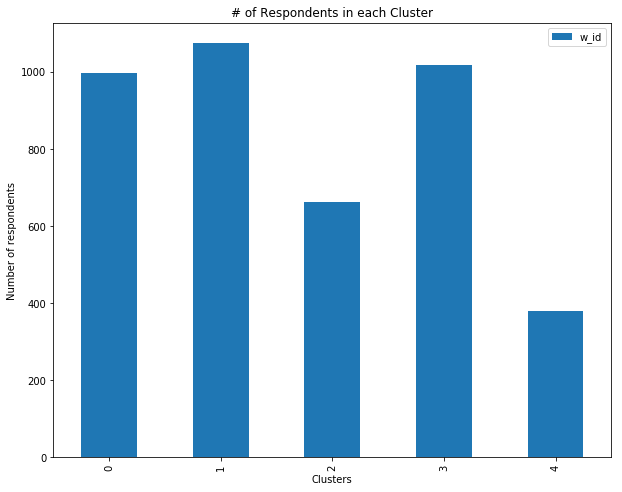

In [65]:
bar_columns = ['Cluster Labels','w_id']
hh_bar=hh_onehot_merged[bar_columns].groupby('Cluster Labels').count()
hh_bar.plot(kind='bar', figsize=(10, 8))

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Number of respondents') # add y-label to the plot
plt.title('# of Respondents in each Cluster') # add title to the plot

plt.show()

Now let's check the number of male and female respondents in each cluster.

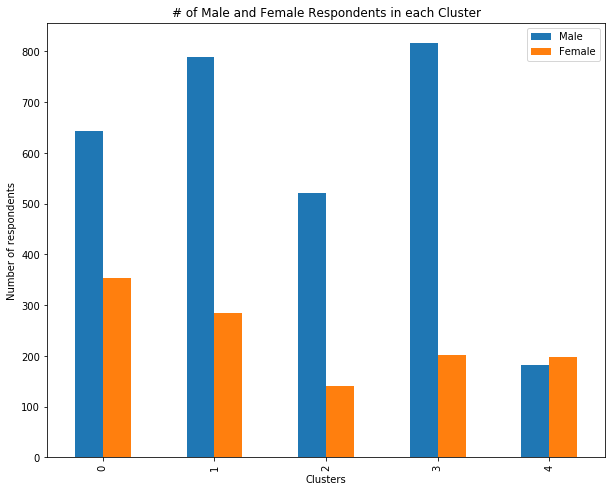

In [66]:
bar_columns = ['Cluster Labels','Male','Female']
hh_bar=hh_onehot_merged[bar_columns].groupby('Cluster Labels').sum()

hh_bar.plot(kind='bar', figsize=(10, 8))

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Number of respondents') # add y-label to the plot
plt.title('# of Male and Female Respondents in each Cluster') # add title to the plot

plt.show()

In [68]:
hh_onehot_merged.groupby('Cluster Labels').mean()

w_id    w_shsn        w_hcn        age    Female  \
Cluster Labels                                                             
0               6.975907e+09  6.666333  3253.081162  62.130261  0.354709   
1               6.999627e+09  6.716946  3626.974860  51.488827  0.265363   
2               7.036905e+09  6.531722  6299.965257  29.838369  0.212991   
3               7.053427e+09  6.574238  4648.512291  41.274336  0.197640   
4               6.983358e+09  6.324538  2688.807388  76.145119  0.519789   

                    Male  Divorced/Separated   Married    Single   Unknown  \
Cluster Labels                                                               
0               0.645291            0.040080  0.629259  0.053106  0.000000   
1               0.734637            0.068901  0.762570  0.051210  0.000931   
2               0.787009            0.031722  0.779456  0.175227  0.000000   
3               0.802360            0.058014  0.852507  0.053097  0.000000   
4               0.480211            0.010554  0.390501  0.039578  0.000000   

                ...  Single house  Dug well    Others  \
Cluster Labels  ...                                     
0               ...      0.822645  0.003006  0.007014   
1               ...      0.764432  0.002793  0.000931   
2               ...      0.672205  0.001511  0.001511   
3               ...      0.713864  0.002950  0.003933   
4               ...      0.831135  0.010554  0.002639   

                Own use, faucet, community water system  \
Cluster Labels                                            
0                                              0.831663   
1                                              0.790503   
2                                              0.716012   
3                                              0.743363   
4                                              0.862797   

                Own use, tubed/piped deep well   Peddler  \
Cluster Labels                                             
0                                     0.003006  0.051102   
1                                     0.003724  0.048417   
2                                     0.004532  0.074018   
3                                     0.001967  0.057030   
4                                     0.007916  0.029024   

                Shared, faucet, community water system  \
Cluster Labels                                           
0                                             0.095190   
1                                             0.130354   
2                                             0.179758   
3                                             0.171091   
4                                             0.073879   

                Shared, tubed/piped deep well  Tubed/piped shallow well  \
Cluster Labels                                                            
0                                    0.008016                  0.001002   
1                                    0.021415                  0.000000   
2                                    0.021148                  0.001511   
3                                    0.014749                  0.001967   
4                                    0.013193                  0.000000   

                With Electricity  
Cluster Labels                    
0                       0.000000  
1                       0.001862  
2                       0.000000  
3                       0.002950  
4                       0.000000  

[5 rows x 90 columns]

Then we need to manually go through the columns and determine the differentiating factor or characteristic of each cluster.

We need to scroll through the columns based on which column these values that have been encoded were originally a part of.

For example, the columns 'Female' and 'Male' were originally under the column for 'sex' and so should be analyzed together. The same for 'Divorced/Separated', 'Married', 'Single', and 'Unknown' which were originally under 'ms' column for Marital Status.

In [95]:
# displays the columns based on specific integer indexes
start_index = 0
end_index = 12
hh_onehot_merged.groupby('Cluster Labels').mean().iloc[:,start_index:end_index]

w_id    w_shsn        w_hcn        age    Female  \
Cluster Labels                                                             
0               6.975907e+09  6.666333  3253.081162  62.130261  0.354709   
1               6.999627e+09  6.716946  3626.974860  51.488827  0.265363   
2               7.036905e+09  6.531722  6299.965257  29.838369  0.212991   
3               7.053427e+09  6.574238  4648.512291  41.274336  0.197640   
4               6.983358e+09  6.324538  2688.807388  76.145119  0.519789   

                    Male  Divorced/Separated   Married    Single   Unknown  \
Cluster Labels                                                               
0               0.645291            0.040080  0.629259  0.053106  0.000000   
1               0.734637            0.068901  0.762570  0.051210  0.000931   
2               0.787009            0.031722  0.779456  0.175227  0.000000   
3               0.802360            0.058014  0.852507  0.053097  0.000000   
4               0.480211            0.010554  0.390501  0.039578  0.000000   

                 Widowed  Agriculture, Forestry, and Fishery Programs  
Cluster Labels                                                         
0               0.277555                                     0.002004  
1               0.116387                                     0.003724  
2               0.013595                                     0.001511  
3               0.036382                                     0.000983  
4               0.559367                                     0.002639

The summary of cluster characteristics are in the dataframe below.

In [94]:
body = client_f4371cfd7e9e4070a8e9ca90826c40e0.get_object(Bucket='courseracapstoneproject-donotdelete-pr-6vs6wawwpvai5j',Key='Cluster Summary v1.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cluster_summary = pd.read_excel(body)
cluster_summary

Cluster  Age  Gender        Marital status   \
0        0   62  Mostly male   Mostly married    
1        1   51  Mostly male   Mostly married    
2        2   29  Mostly male   Mostly married    
3        3   41  Mostly male   Mostly married    
4        4   76  About equal   Mostly widowed    

  Highest Grade                                              Job/Bus Y/N   \
0  HS (.303), Elem (.146)                        ...         About equal    
1  HS (.397), Bus & Admin (.082)                 ...         Mostly with    
2   HS (.375), 2nd Yr Col (.076), Bus & Admin (.056)         Mostly with    
3   HS (.401), 2nd Yr Col (.058), Bus & Admin (.055)         Mostly with    
4  HS (.259), Elementary (.189)                  ...         Mostly no      

      Worker Class  Household              Type of Bldg   \
0      Mostly none  About equal            Single house    
1  Mostly Pvt Corp  Mostly single family   Single house    
2  Mostly Pvt Corp  Mostly single family   Single house    
3  Mostly Pvt Corp  Mostly single family   Single house    
4      Mostly none  About equal            Single house    

  Source of Water Supply  
0       Mostly community  
1       Mostly community  
2       Mostly community  
3       Mostly community  
4       Mostly community

Let us check our clusters against some food expenditure data.

In [87]:
body = client_f4371cfd7e9e4070a8e9ca90826c40e0.get_object(Bucket='courseracapstoneproject-donotdelete-pr-6vs6wawwpvai5j',Key='FIES 2015 Vol2 - Food Expenditure NCR v3 - ColsRed.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

food_exp = pd.read_excel(body)
food_exp.head()

w_regn        w_id  w_shsn  w_hcn tcereal  trice tcorn tflour  \
0  Region XIII - NCR  3901005000       4    101   21969  13000     -    108   
1  Region XIII - NCR  3901005000       5   8003   22158  17550     -     90   
2  Region XIII - NCR  3901005000       6   8001   13260   8450     -      -   
3  Region XIII - NCR  3901005000       7   8005   20996  12350     -      -   
4  Region XIII - NCR  3901005000       9   8004   17060  13350   156      -   

  tothercereal tbread  ... thoney tchocolate tice tothersugar tfoodnec  \
0         3148   5083  ...      -          -    -           -     4844   
1            -   4518  ...      -          -    -           -     5224   
2         2483   2327  ...      -          -  520         468      210   
3         2795   4486  ...      -          -  873           -     4285   
4            -   3248  ...      -          -    -           -     4166   

  tcoffee ttea tcocoa tnonalcohol trestaurant  
0    1118    -      -        1598       52640  
1    1040    -      -        1300       44140  
2    2172    -      -         699       23710  
3    3054    -      -        2778      102790  
4    2744    -      -        3448       45600  

[5 rows x 47 columns]

Some of these columns have been assigned an object data type due to missing data with '.' (dots) and '-' (dashes).

For these supposedly numeric food expenditure columns, let us replace these with the numpy NaN (not a number) value.

In [88]:
cols_to_replace=['tcereal', 'trice', 'tcorn',
       'tflour', 'tothercereal', 'tbread', 'tpasta', 'tmeat', 'tmfresh',
       'tmbeef', 'tmpork', 'tmgoat', 'tmchick', 'tmother', 'tmeatfrozen',
       'tmdried', 'tmpreserve', 'tmtocino', 'tmhotdog', 'tmcbeef', 'tmlmeat',
       'tmsausge', 'tmsalami', 'tmpother', 'tfish', 'tmilk', 'teggs',
       'tomcegg', 'toil', 'tfruit', 'tveg', 'tsugar', 'tjamsmar', 'thoney',
       'tchocolate', 'tice', 'tothersugar', 'tfoodnec', 'tcoffee', 'ttea',
       'tcocoa', 'tnonalcohol', 'trestaurant']

for column in cols_to_replace:
#     print(column)
    food_exp.loc[:,column].replace('.',np.NaN,inplace=True)
    food_exp.loc[:,column].replace('-',np.NaN,inplace=True)

food_exp.dtypes

w_regn           object
w_id              int64
w_shsn            int64
w_hcn             int64
tcereal         float64
trice           float64
tcorn           float64
tflour          float64
tothercereal    float64
tbread          float64
tpasta          float64
tmeat           float64
tmfresh         float64
tmbeef          float64
tmpork          float64
tmgoat          float64
tmchick         float64
tmother         float64
tmeatfrozen     float64
tmdried         float64
tmpreserve      float64
tmtocino        float64
tmhotdog        float64
tmcbeef         float64
tmlmeat         float64
tmsausge        float64
tmsalami        float64
tmpother        float64
tfish           float64
tmilk           float64
teggs           float64
tomcegg         float64
toil            float64
tfruit          float64
tveg            float64
tsugar          float64
tjamsmar        float64
thoney          float64
tchocolate      float64
tice            float64
tothersugar     float64
tfoodnec        

With most columns now being treated as int of float, we can proceed to merge with our clustered dataframe.

In [89]:
# merge onehot & clustered dataframe with food expenditure data
food_merged=pd.merge(hh_onehot_merged, food_exp, left_on=['w_regn','w_id','w_shsn','w_hcn'], right_on=['w_regn','w_id','w_shsn','w_hcn'])
food_merged.head()

Cluster Labels             w_regn        w_id  w_shsn  w_hcn  age  Female  \
0               0  Region XIII - NCR  3901005000       4    101   62       0   
1               4  Region XIII - NCR  3901005000       5   8003   73       1   
2               2  Region XIII - NCR  3901005000       6   8001   23       1   
3               3  Region XIII - NCR  3901005000       7   8005   42       0   
4               0  Region XIII - NCR  3901005000       9   8004   57       0   

   Male  Divorced/Separated  Married  ...  thoney  tchocolate   tice  \
0     1                   0        0  ...     NaN         NaN    NaN   
1     0                   0        0  ...     NaN         NaN    NaN   
2     0                   0        0  ...     NaN         NaN  520.0   
3     1                   0        1  ...     NaN         NaN  873.0   
4     1                   0        1  ...     NaN         NaN    NaN   

   tothersugar  tfoodnec  tcoffee  ttea  tcocoa  tnonalcohol  trestaurant  
0          NaN    4844.0   1118.0   NaN     NaN       1598.0      52640.0  
1          NaN    5224.0   1040.0   NaN     NaN       1300.0      44140.0  
2        468.0     210.0   2172.0   NaN     NaN        699.0      23710.0  
3          NaN    4285.0   3054.0   NaN     NaN       2778.0     102790.0  
4          NaN    4166.0   2744.0   NaN     NaN       3448.0      45600.0  

[5 rows x 135 columns]

Let's display the columns and the data types.

In [90]:
food_merged.dtypes

Cluster Labels                                   int32
w_regn                                          object
w_id                                             int64
w_shsn                                           int64
w_hcn                                            int64
age                                              int64
Female                                           uint8
Male                                             uint8
Divorced/Separated                               uint8
Married                                          uint8
Single                                           uint8
Unknown                                          uint8
Widowed                                          uint8
Agriculture, Forestry, and Fishery Programs      uint8
Architecture and Building Programs               uint8
Arts Programs                                    uint8
Basic Programs                                   uint8
Business and Administration Programs             uint8
Computing/

Now let's display the sum of expenditure on food per cluster.

In [91]:
# displays the sum of vegetable food expenditure per cluster
food_merged[['Cluster Labels','tveg']].loc[food_merged['tveg']!=0,['Cluster Labels','tveg']].groupby('Cluster Labels').sum()

tveg
Cluster Labels           
0               6093869.0
1               6712543.0
2               2716619.0
3               5668370.0
4               2075222.0

Let's put that into a bar graph.

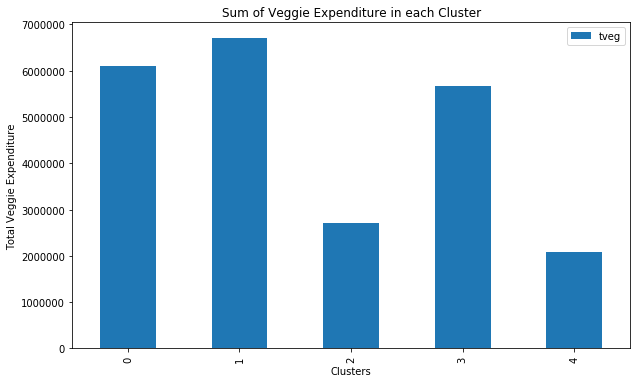

In [92]:
bar_columns = ['Cluster Labels','tveg']
hh_bar=food_merged[bar_columns].groupby('Cluster Labels').sum()

hh_bar.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Total Veggie Expenditure') # add y-label to the plot
plt.title('Sum of Veggie Expenditure in each Cluster') # add title to the plot

plt.show()

To compare, let's also include the meat expenditure in the bar graph.

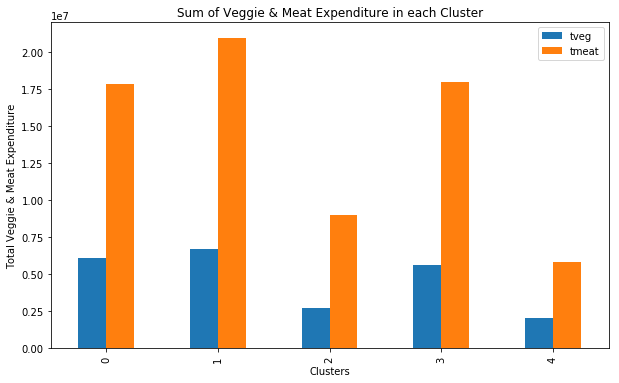

In [93]:
bar_columns = ['Cluster Labels','tveg','tmeat']
hh_bar=food_merged[bar_columns].groupby('Cluster Labels').sum()

hh_bar.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Total Veggie & Meat Expenditure') # add y-label to the plot
plt.title('Sum of Veggie & Meat Expenditure in each Cluster') # add title to the plot

plt.show()

We can observe here that food expenditure is significantly greater for meat compared to vegetables. Across clusters, there is greater vegetable expenditure for clusters 0, 1, and 3 in terms of total amount. However, let us check on a per-head basis because the number of respondents is not the same across clusters.

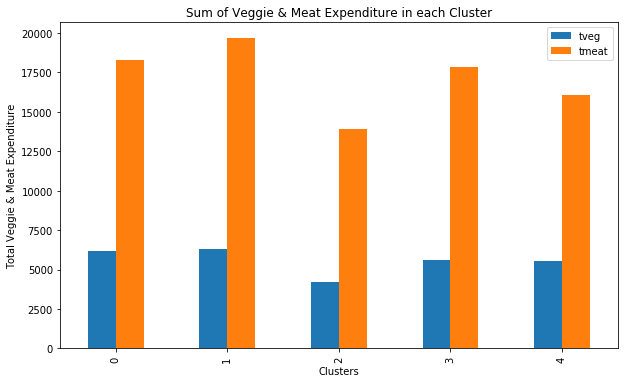

In [96]:
bar_columns = ['Cluster Labels','tveg','tmeat']
hh_bar=food_merged[bar_columns].groupby('Cluster Labels').sum()/food_merged[bar_columns].groupby('Cluster Labels').count()

hh_bar.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Clusters') # add to x-label to the plot
plt.ylabel('Total Veggie & Meat Expenditure') # add y-label to the plot
plt.title('Sum of Veggie & Meat Expenditure in each Cluster') # add title to the plot

plt.show()

Here, relative to the number of respondents, the consumption of vegetables is about the same. While the consumption of meat is still greater for some clusters though not by a large margin.

<h2><font size = 3>Conclusion</font></h2>

In summary, based on all of the analysis, we have the following insights:
1. Vegetarian/vegan or plant-based locations in Metro Manila are concentrated only in Makati and Quezon City and only in certain areas within those cities.
2. People eat roughly 3x more meat compared to vegetables based on the 2015 survey data for Metro Manila.

If the conclusions from the various studies, articles, and documentaries are indeed true, it is the hope then that (on the supply side) more venues would open, and (on the demand side) more people would be made aware and seek to eat vegetarian/vegan or plant-based meals. While the goal is not to totally eradicate meat, but the hope is the proportion of vegetable consumption to meat would increase in the future.